This notebook is for sanity. In specific to get the absolute and relative failure rate

In [1]:
import polars as pl
from data_io.loader.data_loader import DataLoader
import matplotlib.pyplot as plt
from analysis.sanity.sanity_helpers import station_outage_rate

dl = DataLoader()


Get the absolute and relative failure rate data of every station

In [2]:
outages = station_outage_rate(dl)
pl.Config.set_tbl_rows(100)
outages

station,start,end,expected_hours,missing_hours,outage_rate
str,i64,i64,i64,i64,f64
"""Ziegelhäuser Landstraße""",2019,2025,59645,24747,0.414905
"""Schlierbacher Landstraße""",2019,2025,60216,23915,0.397154
"""Bahnstadtpromenade""",2020,2025,47151,16757,0.35539
"""Hardtstraße""",2020,2025,51456,10549,0.20501
"""Plöck""",2015,2025,88728,7563,0.085238
"""Kurfürstenanlage Querschnitt""",2019,2025,60216,4888,0.081174
"""Berliner Straße Querschnitt""",2020,2025,51456,3944,0.076648
"""Eppelheimer Str. Querschnitt""",2020,2025,51456,2223,0.043202
"""Liebermannstraße""",2018,2025,62929,1571,0.024965


Plot the failure rate data of the output table above

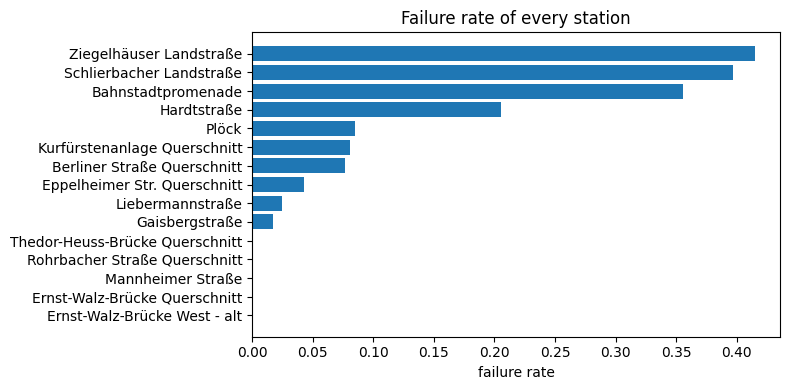

In [3]:


df = outages.sort("outage_rate", descending=True)

plt.figure(figsize=(8, max(4, 0.25 * df.height)))
plt.barh(df["station"], df["outage_rate"])
plt.xlabel("failure rate")
plt.title("Failure rate of every station")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()